## Test other controlnet adapters

[openpose](https://huggingface.co/thibaud/controlnet-openpose-sdxl-1.0)

### > install packages

In [1]:
pip install pandas==2.0.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -Uq ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -Uq opencv-python-headless
!pip install -Uq diffusers==0.21.4
!pip install -Uq controlnet_aux

### > setup

In [2]:
# !pip install opencv-python transformers accelerate
from controlnet_aux import OpenposeDetector
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL
from diffusers.utils import load_image
import numpy as np
import torch
import gc

import cv2
from PIL import Image

device_count = torch.cuda.device_count()
assert device_count > 1, "No GPU devices detected."

print("Number of available GPU devices:", device_count)

device = torch.device("cuda:1")

/opt/conda/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


Number of available GPU devices: 4


### > download reference image

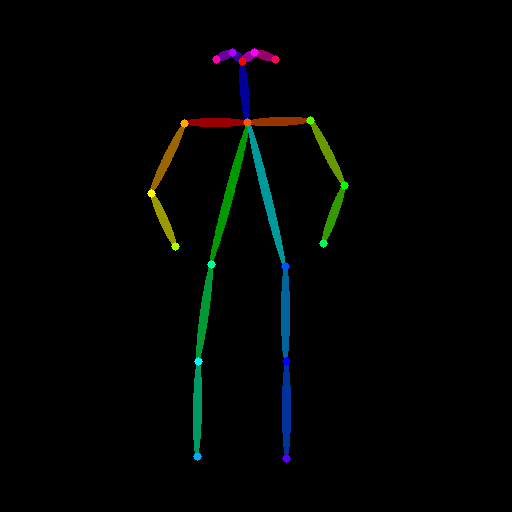

In [3]:
# Compute openpose conditioning image.
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image = openpose(image)
openpose_image

### > load the model

In [4]:
# Initialize ControlNet pipeline.
controlnet = ControlNetModel.from_pretrained("thibaud/controlnet-openpose-sdxl-1.0", torch_dtype=torch.float16).to(device)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", controlnet=controlnet, torch_dtype=torch.float16
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

2024-01-11 07:47:58.905164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
!nvidia-smi

Thu Jan 11 07:48:04 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         Off  | 00000000:00:1B.0 Off |                    0 |
|  0%   47C    P0   230W / 300W |  17456MiB / 22731MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A10G         Off  | 00000000:00:1C.0 Off |                    0 |
|  0%   

### > Generate image

In [6]:
prompt = "Darth vader dancing in a desert, high quality"
negative_prompt = "low quality, bad quality"

In [7]:
%%time
image = pipe(
    prompt, 
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    image=openpose_image.resize((1024, 1024)),
    generator=torch.manual_seed(97),
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB (GPU 1; 22.20 GiB total capacity; 16.56 GiB already allocated; 725.12 MiB free; 21.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

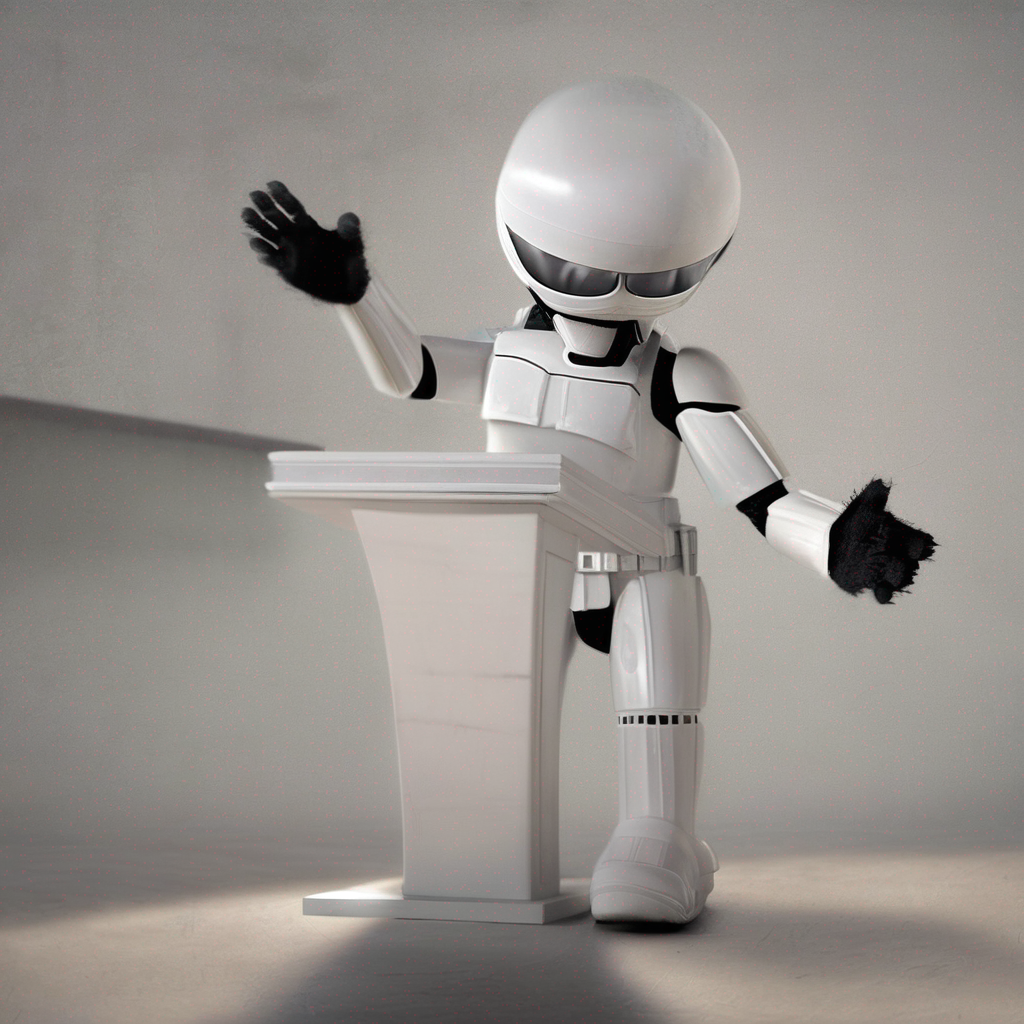

In [9]:
image

### > import your own image

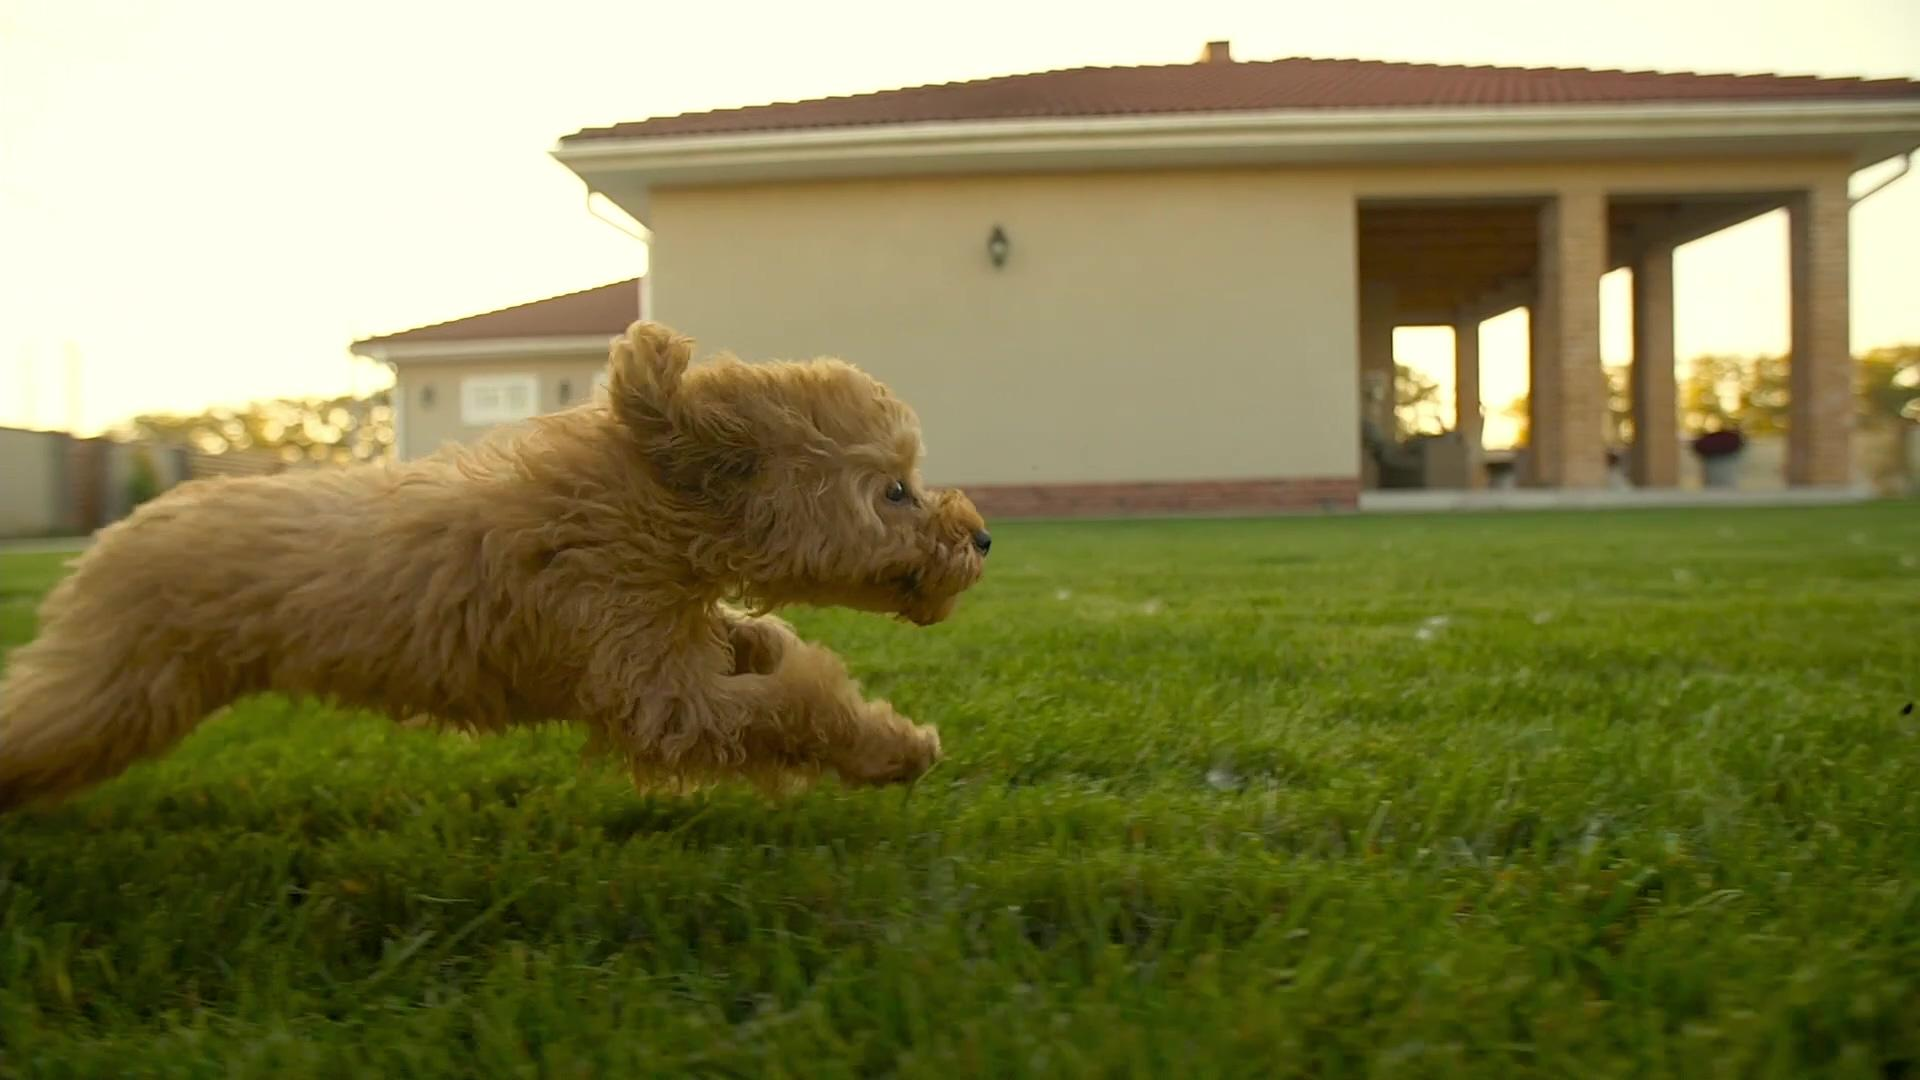

In [16]:
image_path = "dog.jpg"
image = Image.open(image_path)
image

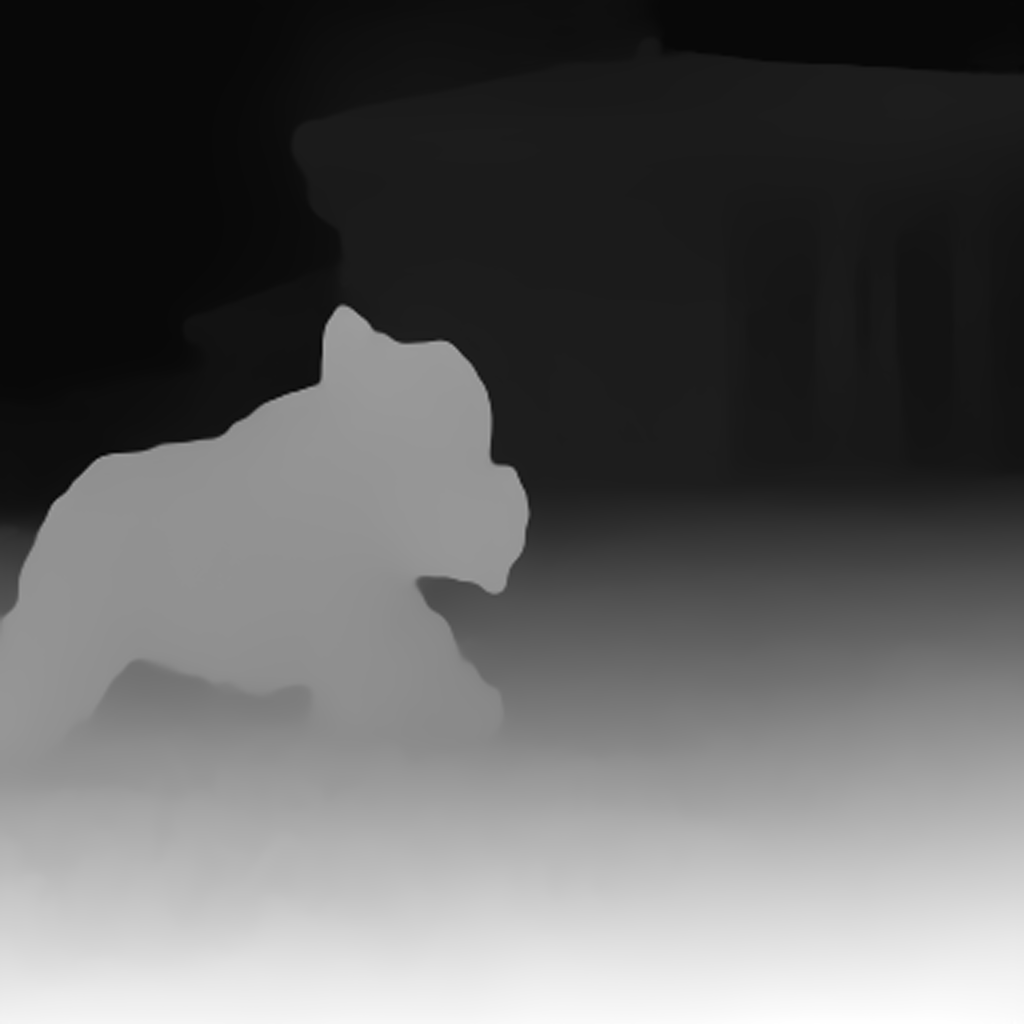

In [17]:
## get depth image
depth_image = get_depth_map(image)
depth_image

In [44]:
prompt="cute panda running, bamboo tree in to background, dark night, large moon, realistic, highly detailed, 8k"
negative_prompt = "extra digit, fewer digits, cropped, worst quality, low quality, glitch, deformed, mutated, ugly, disfigured"

In [45]:
%%time
generator = torch.manual_seed(0)
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=depth_image,
    num_inference_steps=50,
    # guidance_scale=1.5,
    controlnet_conditioning_scale=0.5,
    # cross_attention_kwargs={"scale": 1.0},
    generator=generator,
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 24.9 s, sys: 15.9 s, total: 40.8 s
Wall time: 30.7 s


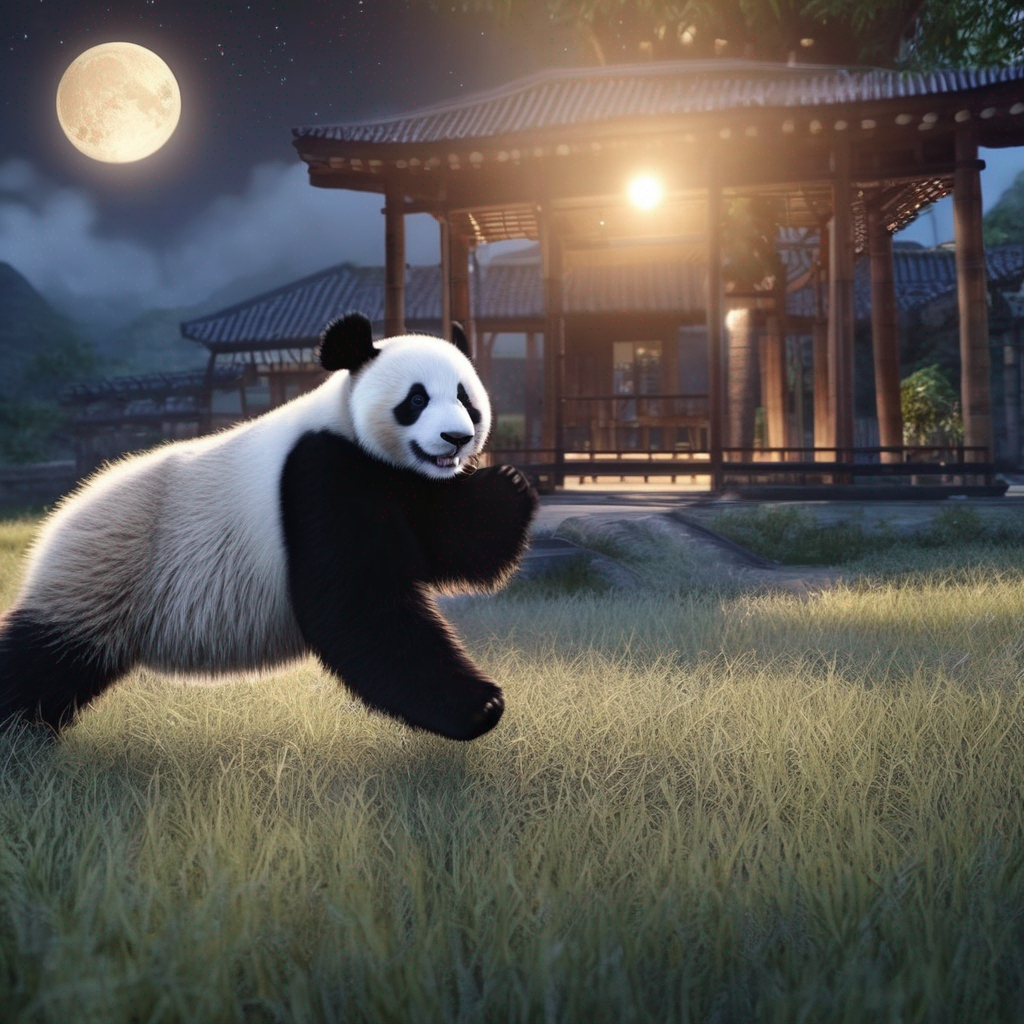

In [46]:
image

In [20]:
del pipe
gc.collect()
torch.cuda.empty_cache()

In [4]:
!nvidia-smi

Thu Jan 11 07:43:49 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         Off  | 00000000:00:1B.0 Off |                    0 |
|  0%   25C    P0    59W / 300W |   4708MiB / 22731MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A10G         Off  | 00000000:00:1C.0 Off |                    0 |
|  0%   